## Lasso model 

In [39]:
# Importing relevant libraries
%load_ext lab_black
import warnings
import urllib

warnings.filterwarnings("ignore")
import math
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import LinearRegression, Ridge, Lasso

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


Loading the data

In [ ]:
data_2021 = pd.read_csv("../data/airbnb_listings_2021.csv")
data_2021.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

Dropping irrelevant columns and those that are unethical to use

In [ ]:
data_2021.drop(
    [
        "id",
        "host_name",
        "last_review",
        "license",
        "name",
        "host_id",
        "number_of_reviews",
        "reviews_per_month",
        "number_of_reviews_ltm",
    ],
    axis=1,
    inplace=True,
)

Replacing the missing values for numerical columns with mean and mode

In [42]:
data_2021["price"] = data_2021["price"].fillna(data_2021["price"].mean())
data_2021["minimum_nights"] = data_2021["minimum_nights"].fillna(
    data_2021["minimum_nights"].mean()
)
data_2021["calculated_host_listings_count"] = data_2021[
    "calculated_host_listings_count"
].fillna(data_2021["calculated_host_listings_count"].mean())
data_2021["availability_365"] = data_2021["availability_365"].fillna(
    data_2021["availability_365"].mean()
)
data_2021["neighbourhood_group"] = data_2021["neighbourhood_group"].fillna(
    data_2021["neighbourhood_group"].mode()[0]
)
data_2021.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

label encoding categorical columns

In [43]:
label_encoder = LabelEncoder()
data_2021["neighbourhood_group"] = label_encoder.fit_transform(
    data_2021["neighbourhood_group"]
)
data_2021["neighbourhood"] = label_encoder.fit_transform(data_2021["neighbourhood"])
data_2021["room_type"] = label_encoder.fit_transform(data_2021["room_type"])

Remove outliers

In [44]:
z_scores = stats.zscore(data_2021)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)
new_data = data_2021[filtered_entries]

Scaling the data

In [45]:
scaler = StandardScaler()
# scaler.fit(new_data)
scaled_features = scaler.fit_transform(new_data)
scaled_features_data = pd.DataFrame(
    scaled_features, index=new_data.index, columns=new_data.columns
)

Creating train and test data

In [46]:
X = scaled_features_data.drop("price", axis=1)
y = scaled_features_data["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25
)

Creating a list of alphas to tune. Alpha is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients.
When alpha is 0 , Lasso regression produces the same coefficients as a linear regression

In [47]:


par = {"alpha": np.logspace(-5, 1, 100)}
lasso = Lasso()
Lasso_model = GridSearchCV(
    estimator=lasso,
    param_grid=par,
    scoring="neg_mean_absolute_error",
    cv=3,
    return_train_score=True,
    verbose=1,
)
Lasso_model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-05, 1.14975700e-05, 1.32194115e-05, 1.51991108e-05,
       1.74752840e-05, 2.00923300e-05, 2.31012970e-05, 2.65608778e-05,
       3.05385551e-05, 3.51119173e-05, 4.03701726e-05, 4.64158883e-05,
       5.33669923e-05, 6.13590727e-05, 7.05480231e-05, 8.11130831e-05,
       9.32603347e-05, 1.07226722e-04, 1.23284674e-04, 1....
       7.05480231e-01, 8.11130831e-01, 9.32603347e-01, 1.07226722e+00,
       1.23284674e+00, 1.41747416e+00, 1.62975083e+00, 1.87381742e+00,
       2.15443469e+00, 2.47707636e+00, 2.84803587e+00, 3.27454916e+00,
       3.76493581e+00, 4.32876128e+00, 4.97702356e+00, 5.72236766e+00,
       6.57933225e+00, 7.56463328e+00, 8.69749003e+00, 1.00000000e+01])},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [48]:
Lasso_model_result = pd.DataFrame(Lasso_model.cv_results_)

Best Value of Alpha

In [49]:
alpha_value = Lasso_model.best_params_
alpha_value

{'alpha': 0.007054802310718645}

Making predictions

In [50]:
sel_val = alpha_value["alpha"]
lasso2 = Lasso(alpha=sel_val)
lasso2.fit(X_train, y_train)


y_train_pred = lasso2.predict(X_train)
y_test_pred = lasso2.predict(X_test)

# R2 Square

lasso_train_r2 = r2_score(y_true=y_train, y_pred=y_train_pred)
lasso_test_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
print("R2 SCORE for LASSO regression on TRAIN data is : ", lasso_train_r2)
print("R2 SCORE for LASSO regression on TEST data is : ", lasso_test_r2)

R2 SCORE for LASSO regression on TRAIN data is :  0.24184358904660375
R2 SCORE for LASSO regression on TEST data is :  0.2447582511064359


R2 on the train and test data are not too different.

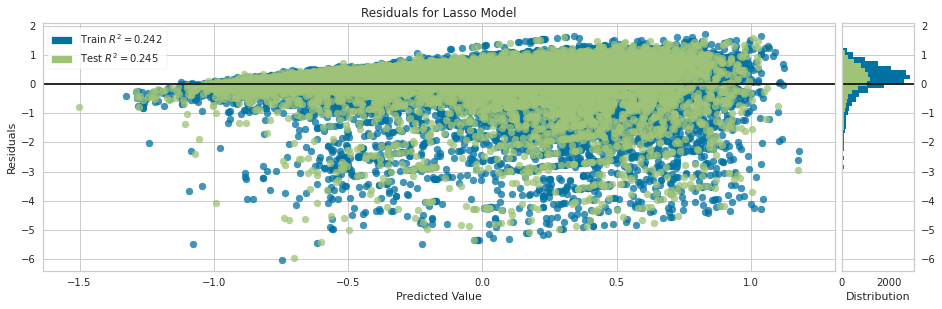

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [56]:
%matplotlib inline
fig = plt.figure(figsize=(13, 4))
lasso_residuals = ResidualsPlot(lasso2)

lasso_residuals.fit(X_train, y_train)  # Fitting the training data to the visualizer
lasso_residuals.score(X_test, y_test)  # Evaluate the model on the test data

fig.tight_layout()
os.makedirs("../artifacts", exist_ok=True)
fig.savefig("../artifacts/lasso_residuals.png", transparent=False)
lasso_residuals.show()

Prediction error graph for the lasso model

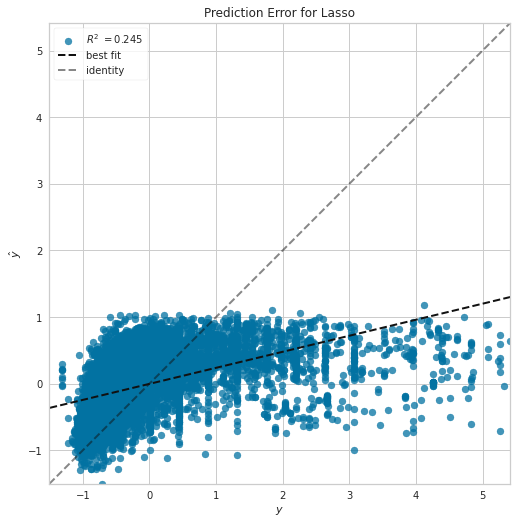

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [38]:
fig = plt.figure(figsize=(13, 7))
lasso_errors = PredictionError(lasso2)

lasso_errors.fit(X_train, y_train)  # Fitting training data
lasso_errors.score(X_test, y_test)  # Using test data to evaluate the model

fig.tight_layout()
os.makedirs("../artifacts", exist_ok=True)
fig.savefig("../artifacts/lasso_errors.png", transparent=False)

lasso_errors.show()

Only the non-zero coefficients are retained in the final model. We can see that varibales minimum_nights, and room_type are negatively related to the dependent variable price. Whereas, variables availability_365, calculated_host_listings_count, neighbourhood and neighbourhood_group are positively related.

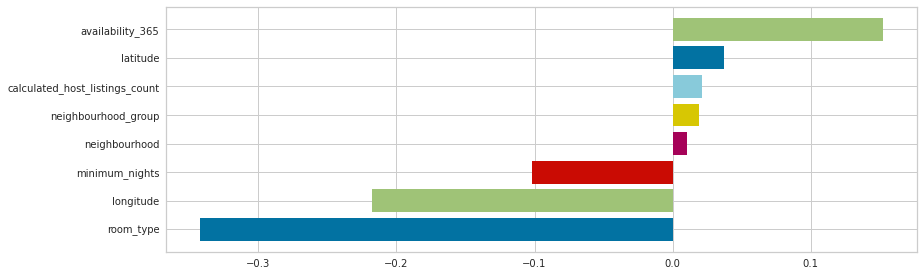

In [34]:
fig = plt.figure(figsize=(13, 4))
lasso_fetures = FeatureImportances(lasso2, relative=False)
lasso_fetures.fit(X_train, y_train)

fig.tight_layout()
os.makedirs("../artifacts", exist_ok=True)
fig.savefig("../artifacts/lasso_fetures.png", transparent=False)

Lasso model selected features in table format

In [35]:
model_parameters = list(lasso2.coef_)
model_parameters.insert(0, lasso2.intercept_)
cols = X_train.columns
cols.insert(0, "const")
lasso_coef = pd.DataFrame(list(zip(cols, model_parameters)))
lasso_coef.columns = ["Feature", "Coefficient"]

# sorting values
lasso_coef.sort_values(by="Coefficient", ascending=True).head(10)

,Feature,Coefficient
5,minimum_nights,-0.341920
4,room_type,-0.217984
6,calculated_host_listings_count,-0.102021
0,neighbourhood_group,0.002161
2,latitude,0.010301
1,neighbourhood,0.019268
7,availability_365,0.021541
3,longitude,0.036996


Actual vs predicted price using test data. Lasso does not do a great job at predicting prices

Text(0.5, 0, 'Index')

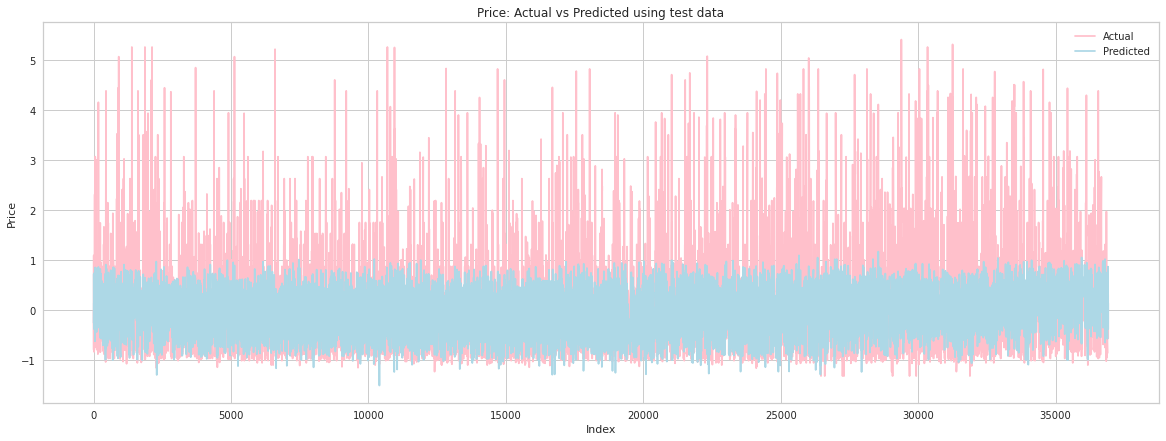

In [36]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.lineplot(x=y_test.index, y=y_test, label="Actual", color="pink", ax=ax)
sns.lineplot(x=y_test.index, y=y_test_pred, label="Predicted", color="lightblue", ax=ax)
ax.set_title("Price: Actual vs Predicted using test data")
ax.set_ylabel("Price")
ax.set_xlabel("Index")

 Lasso

In [37]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

MSE 0.9748322935755408
RMSE 0.9873359578054173


Conclusions from the notebook: 

What we saw in this notebook is that the lasso model doesn't do an amazing job at predicting future prices. The predicted values seldom match the actual values from the model. However, simply looking at the r-squared and the root mean squared error is not sufficient. We need other models in order to draw comparisons. 